# Plot accumulated pollution results

In [1]:
import matplotlib.patches as mpatches
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.patheffects import withStroke
from matplotlib.pyplot import text

from src.tools.plotter import init_plots, store_sns
from src.trace_set.database import Database
from src.trace_set.pollution import PollutionType

init_plots()

In [2]:
POLL_NAMES = {
    PollutionType.gauss: "Gaussian noise",
    PollutionType.desync: "Window jitter"
}

DEFAULT_Y_MAX = 10 ** -40

LIMITS = {
    # X limit, Y limit
    Database.ascad: {
        PollutionType.gauss: (8, DEFAULT_Y_MAX),
        PollutionType.desync: (5, DEFAULT_Y_MAX)
    },
    Database.ascad_none: {
        PollutionType.gauss: (200, DEFAULT_Y_MAX),
        PollutionType.desync: (200, DEFAULT_Y_MAX),
    },
    Database.aisy: {
        PollutionType.gauss: (4000, DEFAULT_Y_MAX),
        PollutionType.desync: (450, 10 ** -160),
    }
}

In [3]:
def get_title(db: Database, poll_type: PollutionType):
    # Database
    res = "ASCAD"
    if db is Database.aisy:
        res = "AISY LA traces"

    # Protection
    if db is Database.ascad:
        res += " (Masked"
    else:
        res += " (Unprotected"

    # Simulated Pollution
    if poll_type is not None:
        res += f", {POLL_NAMES[poll_type]}"

    res += ")\n"

    # Number of traces
    if db is Database.aisy:
        res += "1000 profiling traces, 1000 attack traces"
    else:
        res += "1000 attack traces"

    return res

In [4]:
DLLA_PALETTE = sns.light_palette(sns.color_palette()[0], n_colors=5)
TVLA_PALETTE = sns.light_palette(sns.color_palette()[1], n_colors=5)

THRESHOLD_COLOR = "#FF000080"

In [5]:
methods = {
    "dlla_open": ("DL-LA open-source", DLLA_PALETTE[3], "-"),
    "dlla_closed": ("DL-LA closed-source", DLLA_PALETTE[2], "-"),
    "dlla_wegener": ("Wegener DL-LA", DLLA_PALETTE[1], "-"),
    "tvla_t_1": ("TVLA $t$-test, $\mu_1$", TVLA_PALETTE[3], "--"),
    "tvla_t_2": ("TVLA $t$-test, $\mu_2$", TVLA_PALETTE[2], "--"),
    "tvla_rho": ("TVLA $\\rho$-test", TVLA_PALETTE[1], "--")
}

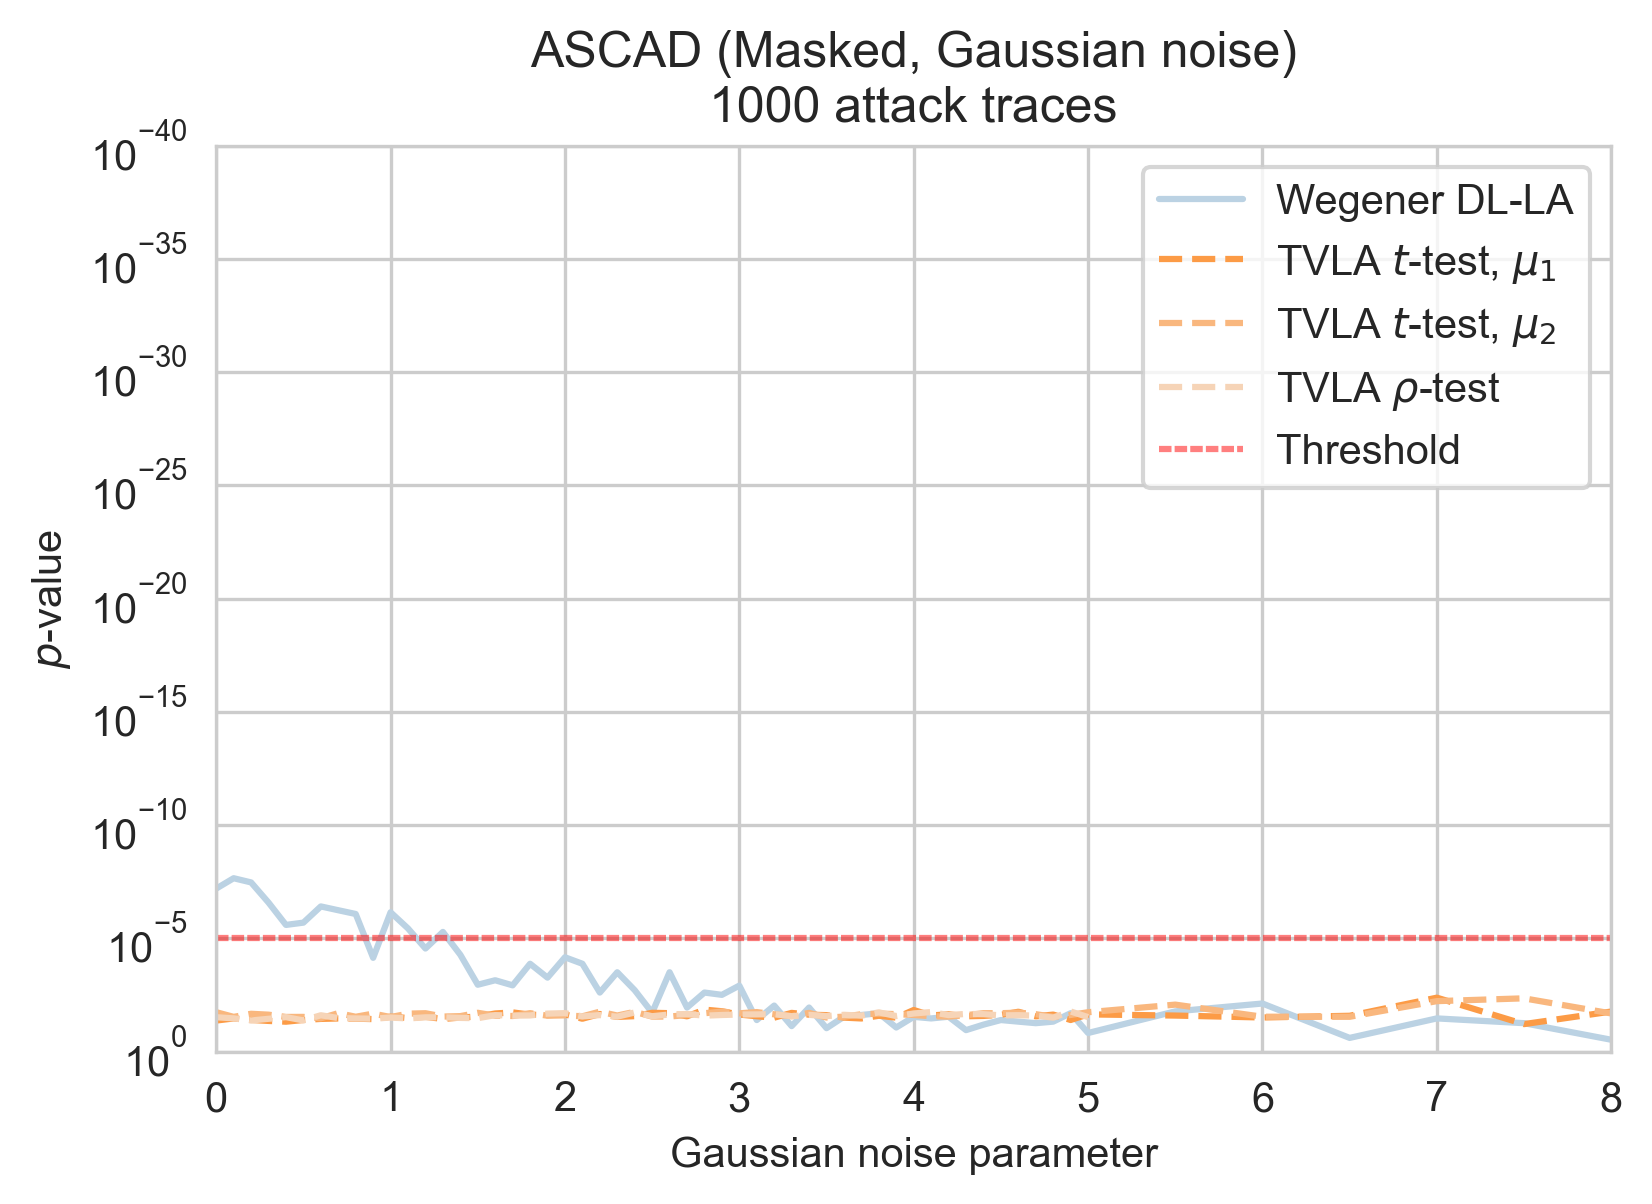

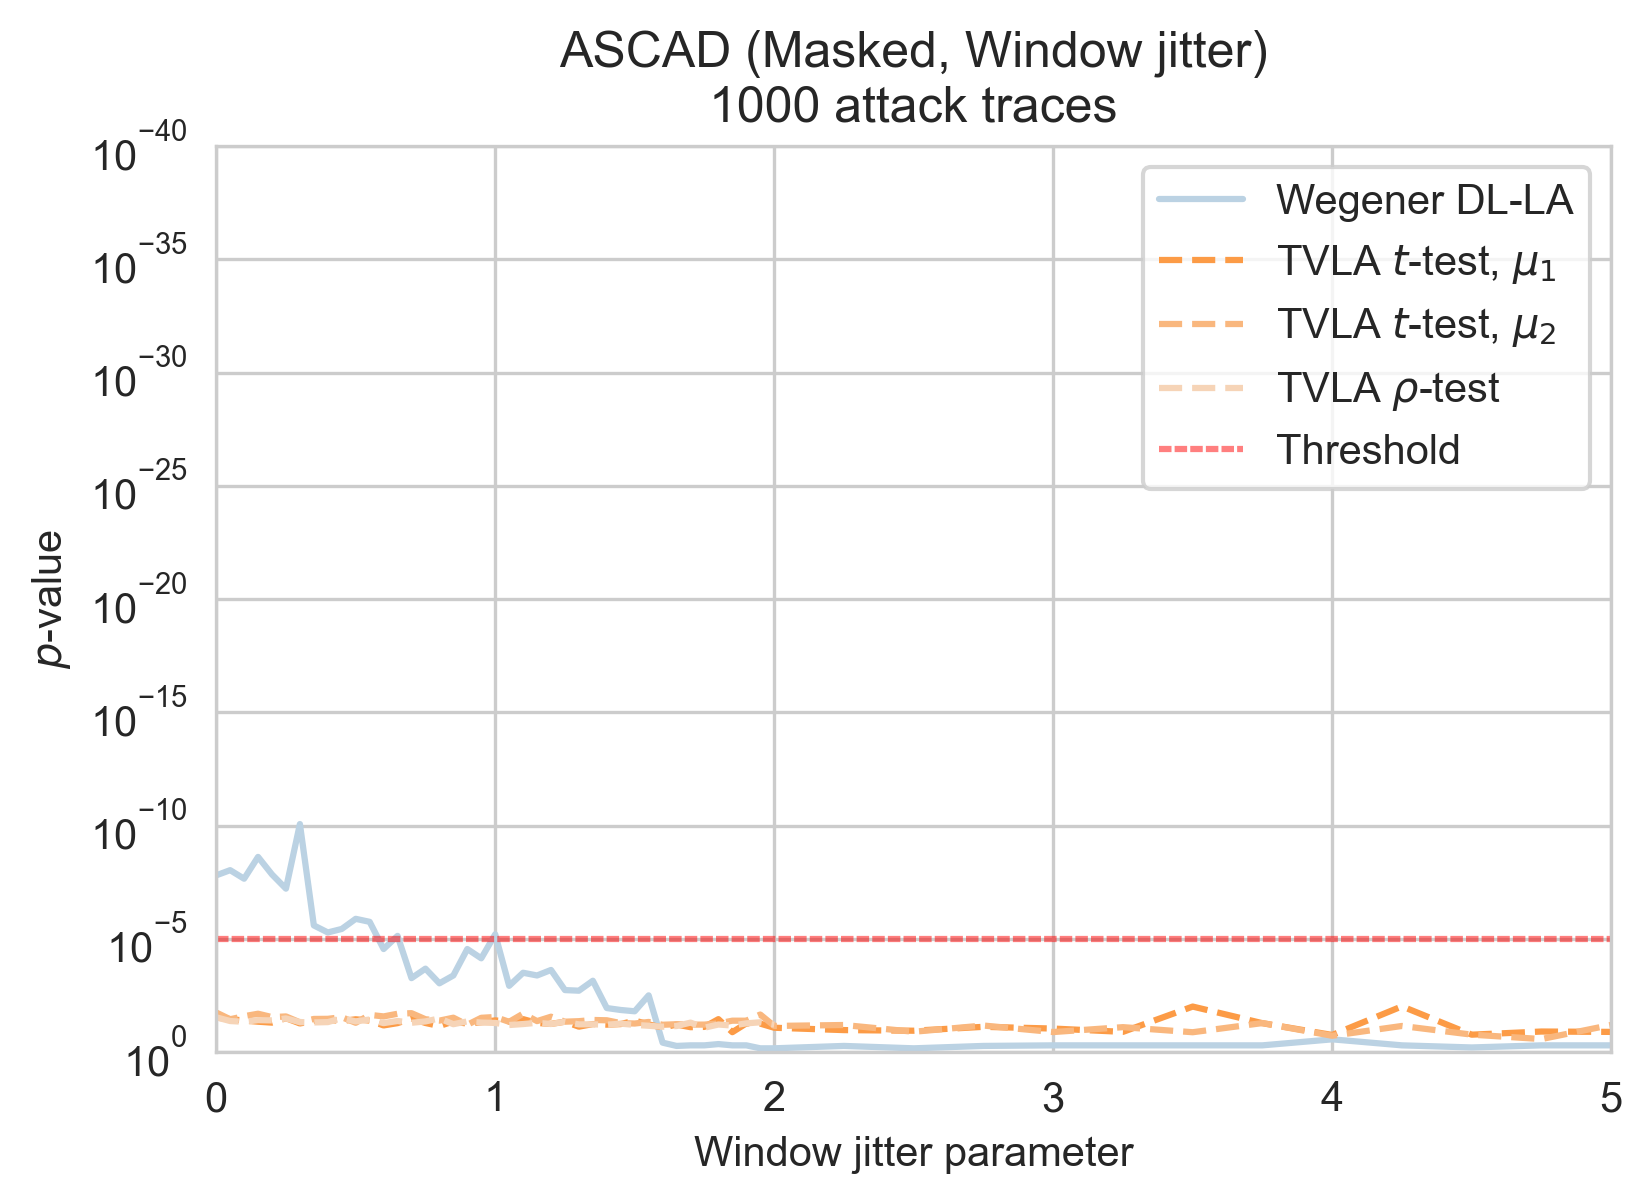

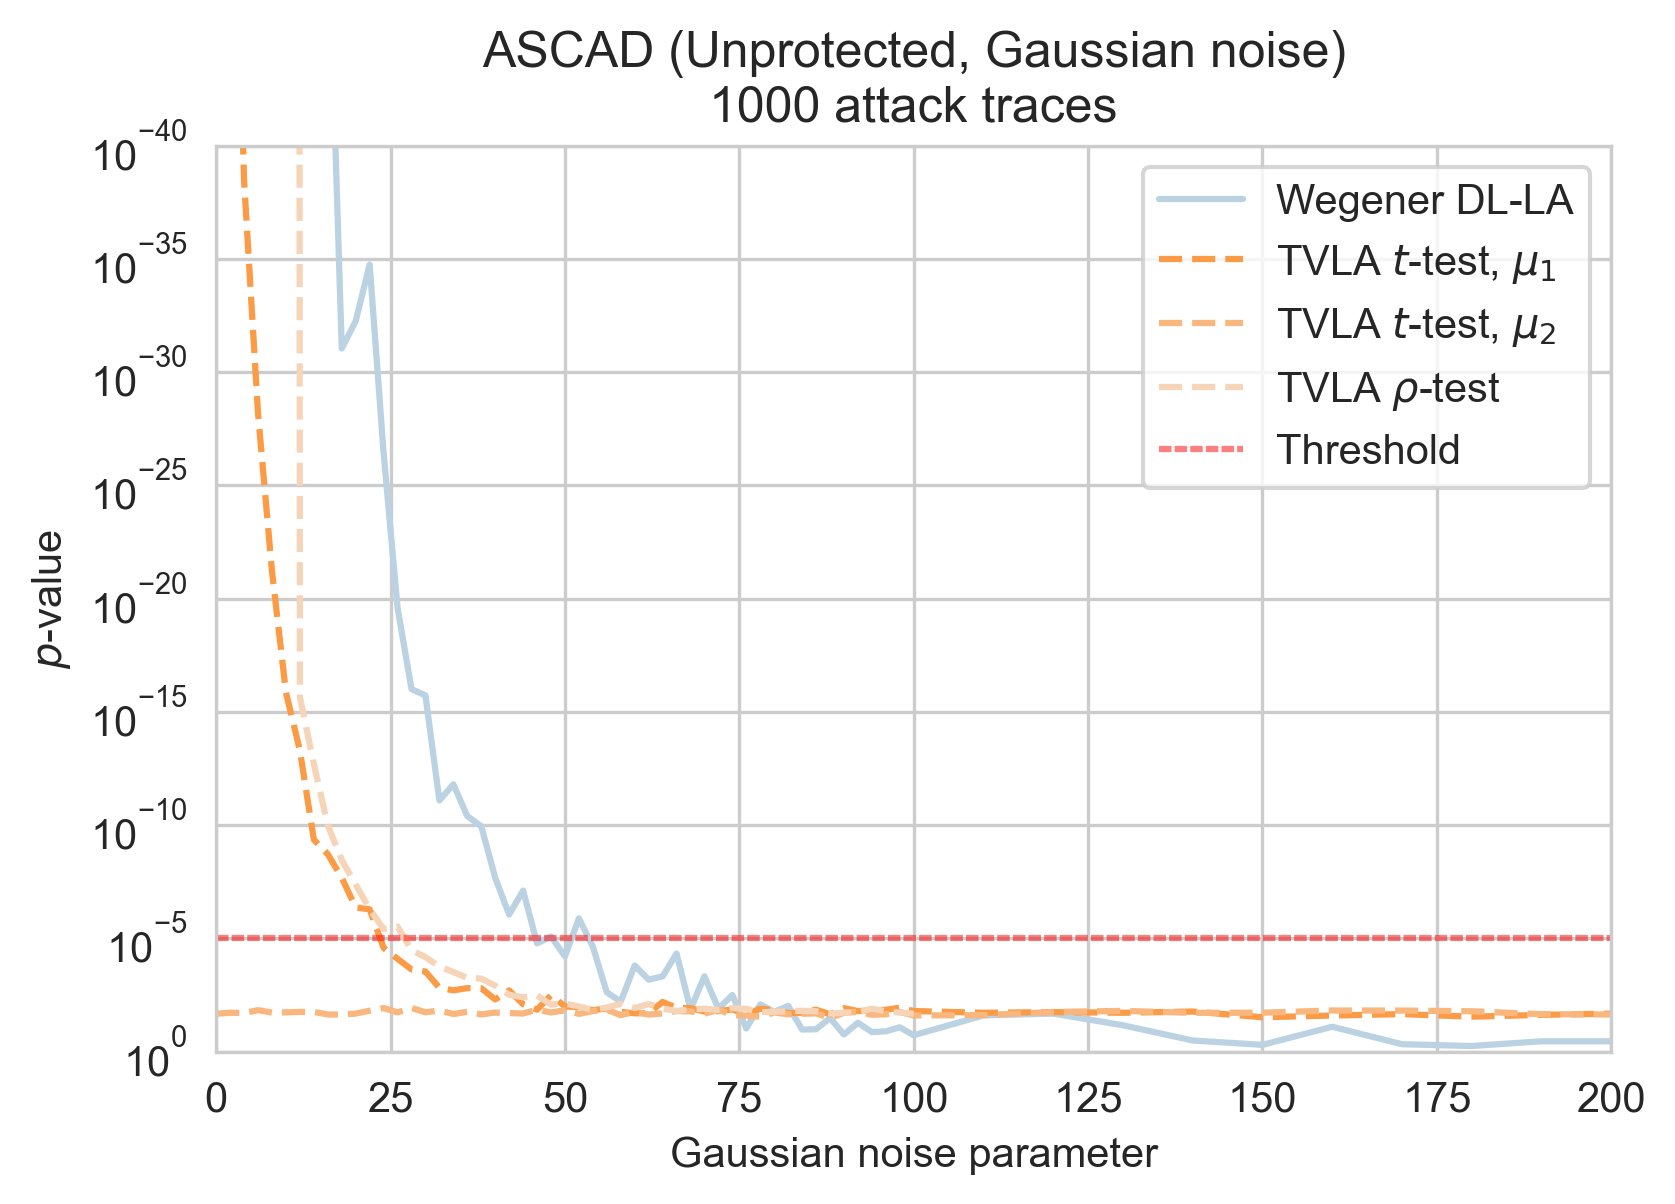

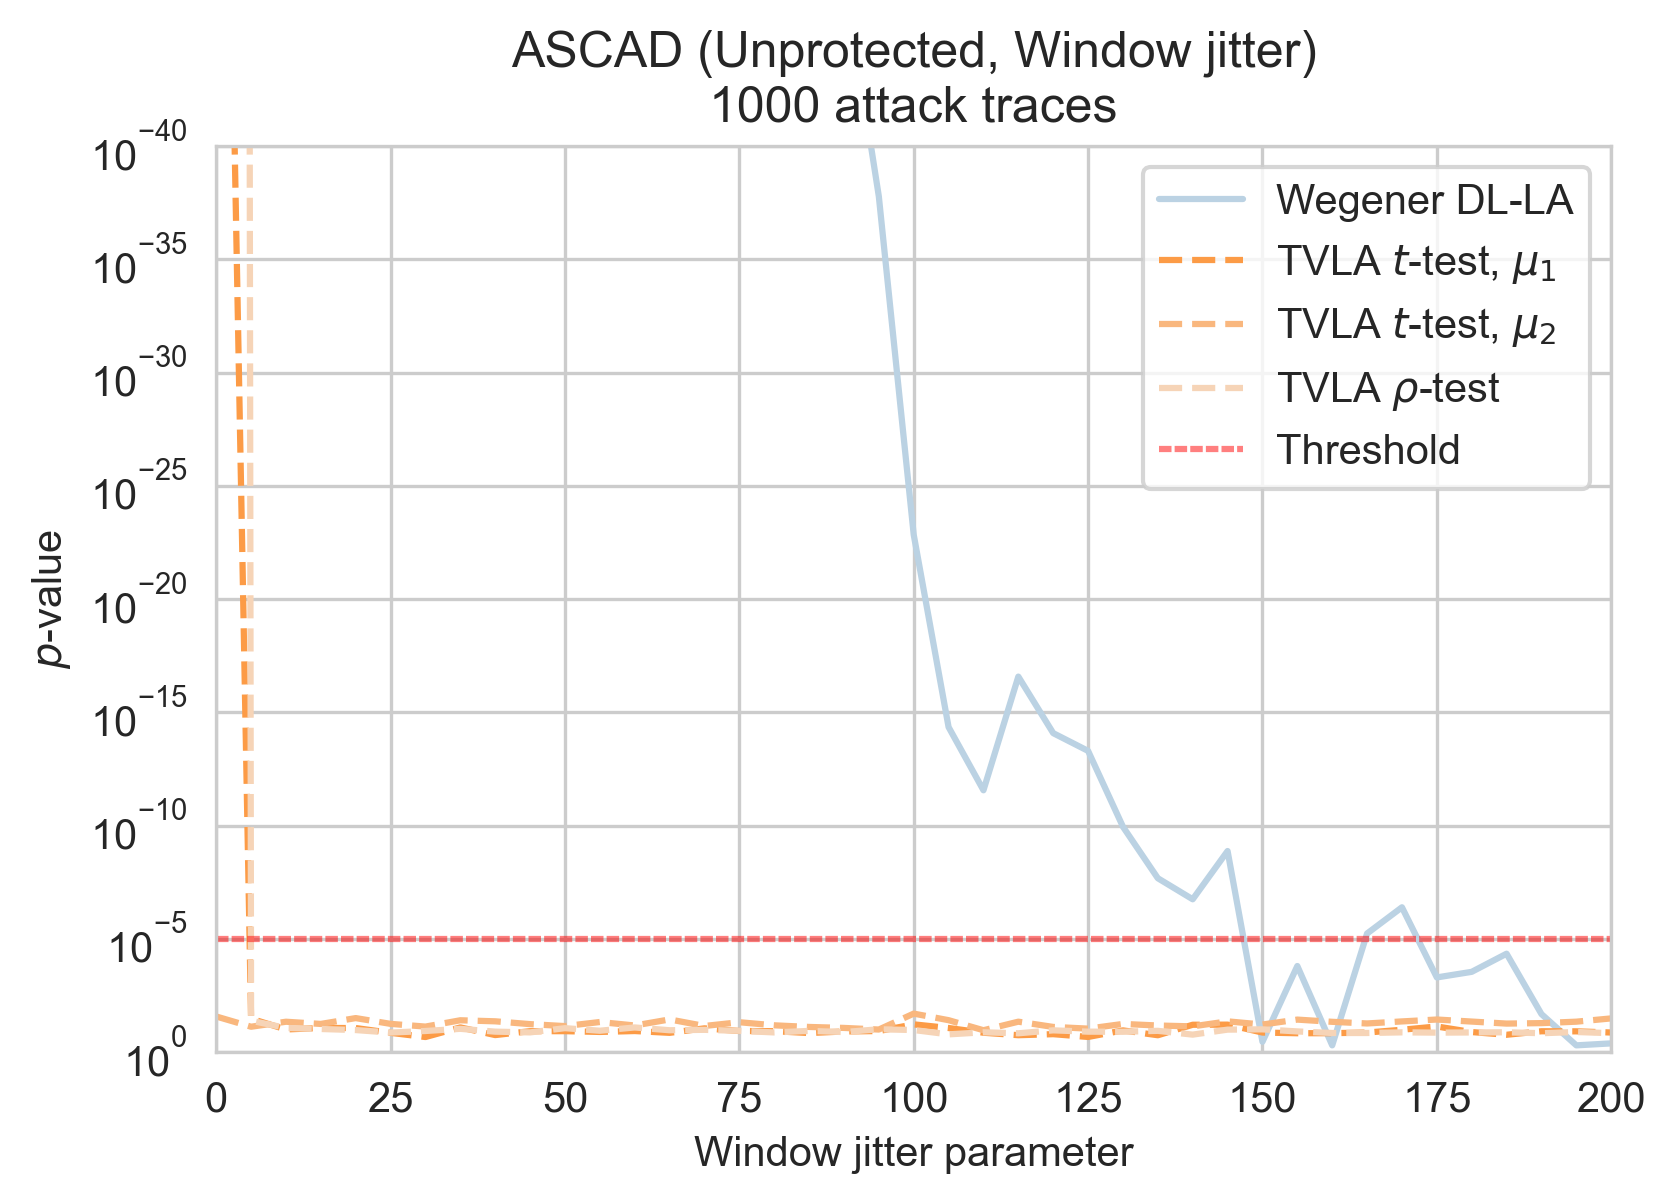

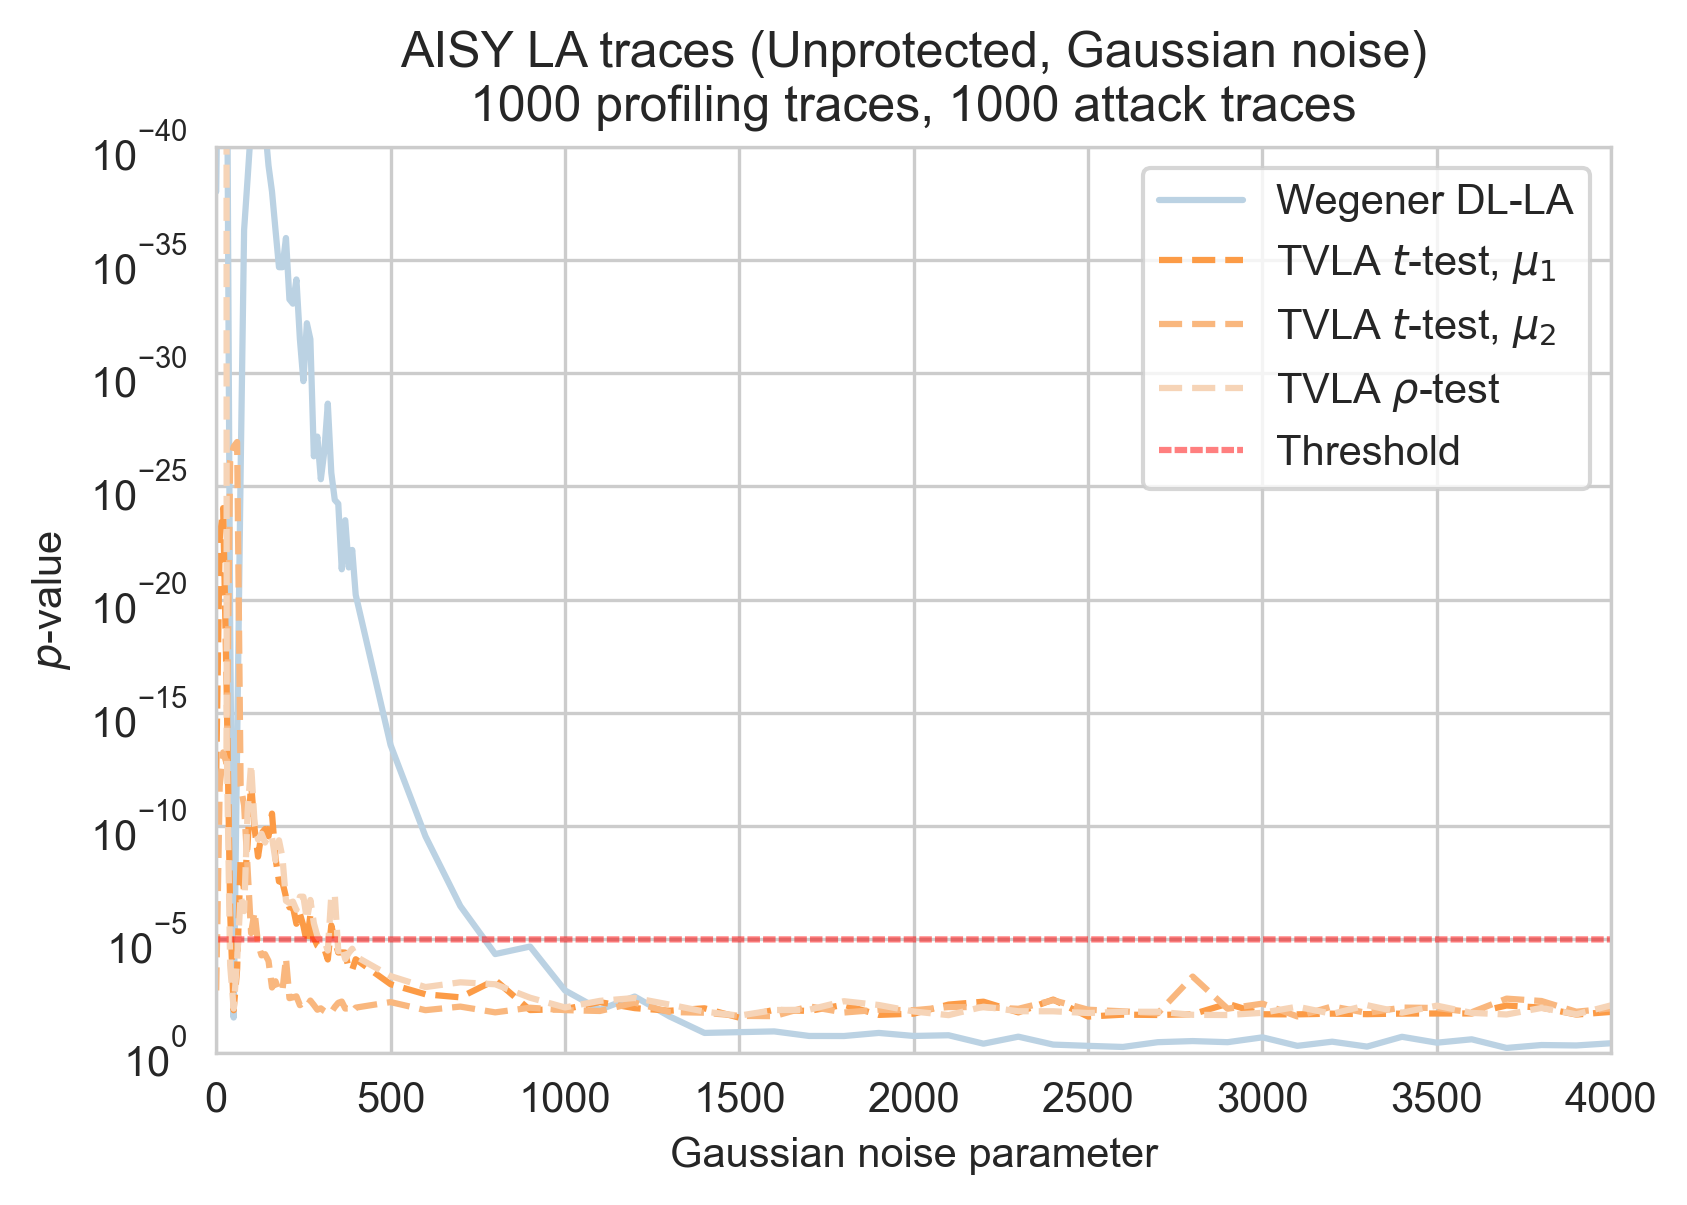

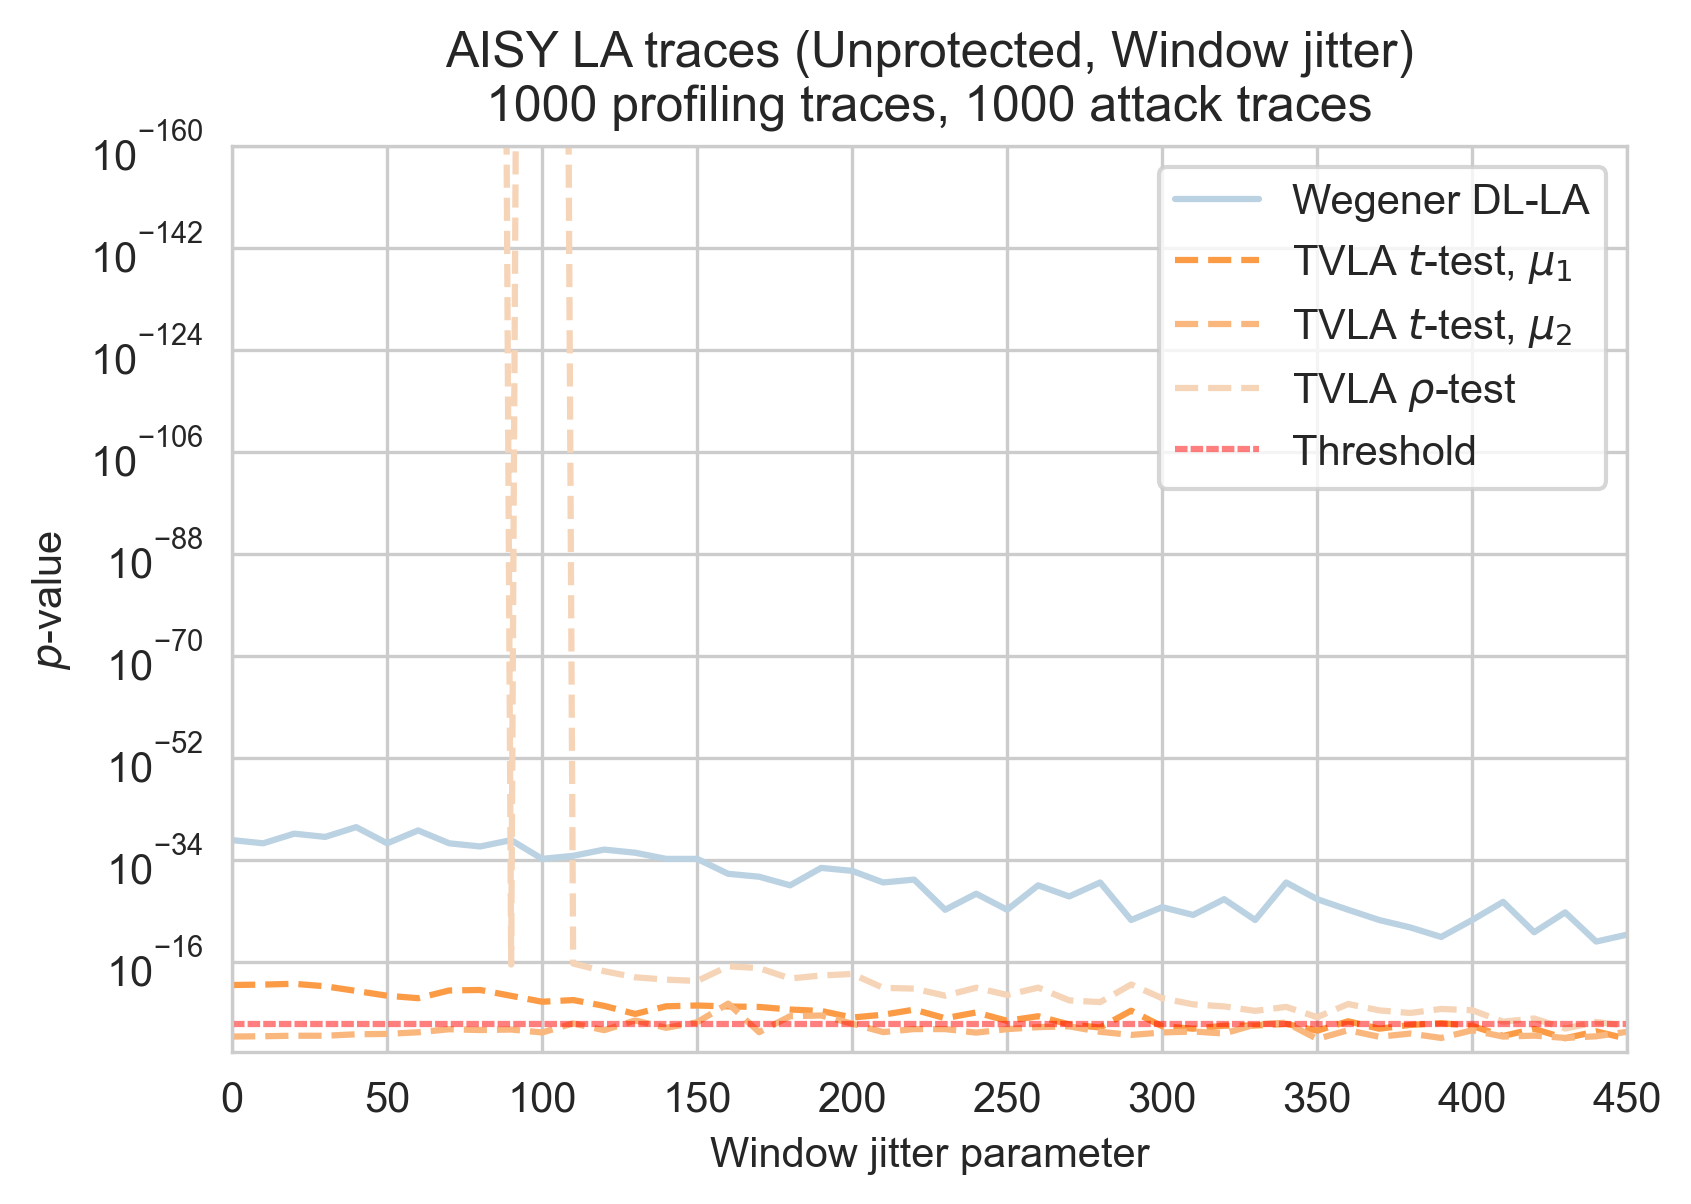

In [6]:
def plot(db: Database, poll_type: PollutionType):
    file_name = f"results_{db.name}.csv"

    df = pd.read_csv(file_name, sep=";")
    df = df[df.pollution == poll_type.name].drop(columns=[df.pollution.name])

    gdf = df.groupby(df.method)

    for method, (label, color, style) in methods.items():
        if method in gdf.groups:
            method_group = gdf.get_group(method)
            med = method_group.groupby(df.param).median()

            sns.lineplot(x=med.param, y=med.p, label=label, color=color, linestyle=style)

    x_max, y_max = LIMITS[db][poll_type]
    xlim, ylim = (0, x_max), (1, y_max)
    len_axis = xlim[1] + 1

    t_line = [10 ** -5] * len_axis
    g = sns.lineplot(data={"Threshold": t_line}, palette=[THRESHOLD_COLOR], dashes=[(2, .5)])
    g.set(yscale="log",
          ylim=ylim,
          xlim=xlim,
          xlabel=f"{POLL_NAMES[poll_type]} parameter",
          ylabel="$p$-value",
          title=get_title(db, poll_type))

    store_sns(g, f"pollution-results-{db.name}-{poll_type.name}")
    plt.show(block=False)

def plot_all():
    for db in [Database.ascad, Database.ascad_none, Database.aisy]:
        for poll_type in [PollutionType.gauss, PollutionType.desync]:
            plot(db, poll_type)

plot_all()